This notebook aims to simulate a data scientist consuming data from a data pipeline, using PySpark. 

In this notebook, I will be executing the following steps:
  - Conduct EDA on data produced from Medallion Data Pipeline 
  - Handling Missing Values 

Thereafter, feature engineering, selection and multicollinearity checks will be handled invidually in their respective notebooks. I have specifically done this, since feature engineering should be targeted for LGD, PD, EAD. Doing feature engineering and producing a master table to use for all 3 models makes our model building tedious, computationally expensive and hard to interpret. 

# 1. Import Libraries

In [1]:
# == Standard libraries == 
import os

# == Load Environment Variables == 
from dotenv import load_dotenv
load_dotenv()

# == Start Spark == 
from init_spark import start_spark
spark = start_spark()

# == Wandb for logging == 
import wandb
wandb.login(key=os.getenv("WANDB_API_KEY"))

# == Pyspark Functions == 
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col,
    when,
    count,
    desc,
    isnan,
    isnull,
    lit,
    length,
    trim,
    lower,
    upper,
    to_date,
    concat_ws,
    regexp_extract,
    sum,
    unix_timestamp,
    from_unixtime,
)

from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    DoubleType,
    IntegerType,
    DateType,
    NumericType,
)

from pyspark.sql import DataFrame
from datetime import date

# == Pandas, Seaborn, Matplotlib == 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

# == Global Functions == 
from functions import * # Import functions from the functions module

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/10 16:36:48 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/08/10 16:36:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/lunlun/.ivy2.5.2/cache
The jars for the packages stored in: /Users/lunlun/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-59a5969e-74eb-48a0-97af-fd012a3b144b;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: 

4.0.0


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc


In [2]:
# ============ Helper Functions ===================

# == Miscellaneous == 
def drop_constant_columns(df):
    """
    Removes all columns in the DataFrame that have only one distinct value.
    Returns a new DataFrame with those columns removed.
    """
    cols_to_drop = []

    for column_name in df.columns:
        if df.select(col(column_name)).distinct().count() <= 1:
            cols_to_drop.append(column_name)

    print(f"⚠️ Dropping constant columns: {cols_to_drop}")
    return df.drop(*cols_to_drop)

# == Outliers Handling ==
def compute_outlier_pct(df, col_name, lower_pct=0.25, upper_pct=0.75):
    '''Computes pct of outliers per column based on IQR method '''
    
    # 1. Compute percentile bounds
    quantiles = df.approxQuantile(col_name, [lower_pct, upper_pct], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1 

    # 2. Obtain lower and upper bound, any data points outside of this are seen as outliers 
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    total_rows = df.count()

    return round(df.filter( (col(col_name) < lower_bound) | (col(col_name) > upper_bound) ).count() / total_rows * 100, 2) 

def display_distributions(df): 
    """Takes in Spark Dataframe. Samples it and display distribution for skewness checking"""
    # 1. Select numerical columns
    numeric_cols = [field.name for field in df.schema if isinstance(field.dataType, NumericType)]

    # 2. Sample small portion of data (e.g., 5%) and convert to pandas
    sample_df = df.select(numeric_cols).sample(fraction=0.1, seed=42)
    sample_pdf = sample_df.toPandas()

    # 3. Plot histograms as subplots
    n_cols = 3  # Number of plots per row
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col_name in enumerate(numeric_cols):
        axes[i].hist(sample_pdf[col_name].dropna(), bins=50, color='skyblue')
        axes[i].set_title(col_name, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def inspect_outliers_iqr(df: DataFrame, columns: list, sample_size: int = 5):
    for col_name in columns:
        try:
            print(f"\n📊 Inspecting Outliers for Column: `{col_name}`")

            # Step 1: Calculate Q1, Q3, and IQR
            q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            print(f"Q1 = {q1}, Q3 = {q3}, IQR = {iqr}")
            print(f"Lower Bound = {lower}, Upper Bound = {upper}")

            # Step 2: Count outliers
            outlier_count = df.filter((col(col_name) < lower) | (col(col_name) > upper)).count()
            total_count = df.count()
            outlier_pct = round(outlier_count / total_count * 100, 2)
            print(f"Outlier Count: {outlier_count} ({outlier_pct}%)")

            # Step 3: Sample outlier values (top and bottom)
            print(f"🔼 Top Outliers (>{upper}):")
            df.filter(col(col_name) > upper).select(col_name).orderBy(col(col_name).desc()).show(sample_size)

            print(f"🔽 Bottom Outliers (<{lower}):")
            df.filter(col(col_name) < lower).select(col_name).orderBy(col(col_name)).show(sample_size)

        except Exception as e:
            print(f"❌ Could not process column `{col_name}`: {str(e)}")

def winsorise_col(df, col_name,operator: str,  condition_val, final_val):
    """
    Winsorises a column by replacing values above a certain condition with a final value.
    
    Args:
        df (DataFrame): The input DataFrame.
        col_name (str): The name of the column to winsorise.
        condition_val (float): The value above which to replace with final_val (cut-off)
        final_val (float): The value to replace with.
        
    Returns:
        DataFrame: The DataFrame with the winsorised column.
    """
    print("✅ Winsorising column:", col_name, "...")
    
    if operator == '<':
        return df.withColumn(col_name, when(col(col_name) < condition_val, final_val).otherwise(col(col_name)))
    
    elif operator == '>':
        return df.withColumn(col_name, when(col(col_name) > condition_val, final_val).otherwise(col(col_name)))

def retain_rows(df: DataFrame, col_name: str, condition_val: float, operator: str) -> DataFrame:
    """
    Retains rows in the DataFrame where the specified column meets a condition.

    Returns:
        DataFrame: The DataFrame with the specified rows dropped.
    """
    
    if operator == '<=':
        return df.filter(col(col_name) <= condition_val)    
    
    elif operator == '<':
        return df.filter(col(col_name) < condition_val)
    
    elif operator == '>':
        return df.filter(col(col_name) > condition_val)
    
    elif operator == '>=':
        return df.filter(col(col_name) >= condition_val)
    
    else:
        raise ValueError("Operator must be '>=' or '<='")

In [3]:
# == Remove all existing runs every time I run this notebook == 
NOTEBOOK_RUN_NAME = 'PD Model Building I'
api = wandb.Api()
for run in api.runs(f"wlunlun1212-singapore-management-university/Credit Risk Modeling"):                      
    if run.group == NOTEBOOK_RUN_NAME:
        run.delete()

In [4]:
df = spark.read.format("delta")\
    .load("../data/gold/medallion_cleaned_lc_data")
    
df.limit(10).toPandas()

25/08/10 16:36:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,credit_history_years
0,22421707,NaN,10000.0,10000.0,10000.0,36,11.67,330.57,B,B4,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,16
1,22341802,NaN,12525.0,12525.0,12525.0,60,25.89,374.19,G,G3,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,5
2,23202765,NaN,3600.0,3600.0,3600.0,36,20.99,135.62,E,E4,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,24
3,21380837,NaN,3000.0,3000.0,3000.0,36,24.08,117.83,F,F2,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,12
4,23183507,NaN,3000.0,3000.0,3000.0,36,17.57,107.82,D,D4,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,19
5,20771894,NaN,2875.0,2875.0,2875.0,36,18.24,104.29,D,D5,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,11
6,22992745,NaN,2000.0,2000.0,2000.0,36,10.15,64.68,B,B2,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,13
7,19596263,NaN,5000.0,5000.0,5000.0,36,9.17,159.40,B,B1,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,13
8,20731108,NaN,8250.0,8250.0,8250.0,36,18.24,299.26,D,D5,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,7
9,21431311,NaN,5000.0,5000.0,5000.0,36,19.52,184.60,E,E2,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,8


In [5]:
df1 = df

# 2. EDA: Summary Statistics & Identify Data Issues

In this section, I will be acting as a data scientist (credit risk modeling) pulling data from the Gold Delta Layer of the Medallion Structure. I will be mainly observing summary statistics, spotting and solving issues (e.g. missing values), understanding distribution of features etc. [](url)


In [6]:
df1.summary().toPandas()

25/08/10 16:37:27 WARN DAGScheduler: Broadcasting large task binary with size 2038.6 KiB


,summary,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term,credit_history_years
0,count,1339155,0,1339155,1339155,1339155,1339155,1339155,1339155,1339155,...,3732,5719,5719,1339155,1339155,33140,33140,33140,33140,1339155
1,mean,5.632850991023817E7,None,14421.497268800102,14413.091557736036,14390.870506804406,41.78888627530047,13.229712684493613,438.06957889115546,None,...,410.32936495176835,10994.577940199337,184.80631054380126,None,None,None,5026.490442365721,47.691254375377326,13.158147254073628,15.802480668779939
2,stddev,3.836608073598585E7,None,8713.595538056368,8709.666221854543,8711.945681379982,10.267528671580818,4.766807743202633,261.3672497536103,None,...,357.6684379796852,7474.319121444204,196.63679451324717,None,None,None,3681.7268836500302,7.305866633564946,8.234771724233394,7.513406780565196
3,min,54734,None,500.0,500.0,0.0,36,5.31,4.93,A,...,1.92,55.73,0.01,Cash,N,ACTIVE,44.21,0.2,0,3
4,25%,19958099,None,8000.0,8000.0,7900.0,36,9.75,248.48,None,...,147.42,5041.17,39.78,None,None,None,2227.0,45.0,6,11
5,50%,57732482,None,12000.0,12000.0,12000.0,36,12.74,375.43,None,...,303.15,9284.28,121.17,None,None,None,4173.91,45.0,14,14
6,75%,84544979,None,20000.0,20000.0,20000.0,36,15.99,580.57,None,...,563.64,15302.56,267.41,None,None,None,6874.91,50.0,18,20
7,max,145636374,None,40000.0,40000.0,40000.0,60,30.99,1719.83,G,...,2343.15,39542.45,1407.86,DirectPay,Y,COMPLETE,33601.0,521.35,181,83


In [7]:
# == Inspect distribution of default vs non-default (to understand existence of class imbalance issues)
df1.groupBy(col('default_status')).count().show()

+--------------+-------+
|default_status|  count|
+--------------+-------+
|             1| 267056|
|             0|1072099|
+--------------+-------+



Based on the summary statistics of the Lending Club dataset, several data quality issues become apparent. 
- Some columns are unusable, due to to having a **large percentage of missing values** (taken reference from `../sandbox/string_issues`)

- A number of features exhibit **missing values**, including `emp_length` etc. This requires imputation strategies to be implemented

- Some columns are irrelevant to our credit risk modeling project, due to **high cardinality** (large number of unique values), e.g. `emp_title` **(categorical data)**. 

- There are also **redundant columns**, like `member_id`, which provides no value to our prediction of LGD, EAD and PD.

- There are also **post-loan information**. This means that the value of these features are generated after loan origination (attaining application and approval). Hence, such features should be dropped, since they would skew our subsequent machine learning models. Such features include `total_pymnt`, `last_pymnt_d`. These shall be removed in individual modelling notebooks, since models like LGD and EAD will require them. 

- There are features like `delinq_2yrs` which have **outliers** (maximum data point way above the 75% quartile)


In [8]:
df2 = df1

# 3. Handling Missing Values

Based on the above issues identified by me with the Lending Club Dataset, I will now be tackling each of them in order. 

### 3.1 Find Null Value % Per Column 
For this credit risk modeling project, I will be dropping columns with &gt; 50% missingness.  Many credit risk modelling projects on Kaggle and Github use 50%-65% missingness as the threshold to drop columns as well. 

However, let's display the columns which have >=50% missing values first to inspect them 

In [9]:
# == Get total number of rows == 
total_rows = df2.count()

# == Calculate % of nulls per column and keep only those ≥ 50% == 
missing_val_threshold = 30
high_missingness_columns = []

for column in df2.columns:
    null_count = df2.select(sum(col(column).isNull().cast("int"))).collect()[0][0]
    null_pct = (null_count / total_rows) * 100
    if null_pct >= missing_val_threshold:
        print(f"{column}: {null_pct:.2f}% null")
        high_missingness_columns.append(column)

# == Drop columns with >= 50% missing values (Low predictive power upon inspection) == 
df2 = df2.drop(*high_missingness_columns) 
print("\n✅ Columns with high pct of missing values dropped ... \n")

# == Inspect Dimensions == 
num_rows = df2.count()
num_cols = len(df2.columns)
print(f"Updated Shape: ({num_rows}, {num_cols})")

member_id: 100.00% null
mths_since_last_delinq: 50.43% null
mths_since_last_record: 82.96% null
next_pymnt_d: 100.00% null
mths_since_last_major_derog: 73.68% null
annual_inc_joint: 98.11% null
dti_joint: 98.11% null
verification_status_joint: 98.12% null
open_acc_6m: 60.04% null
open_act_il: 60.04% null
open_il_12m: 60.04% null
open_il_24m: 60.04% null
mths_since_rcnt_il: 61.09% null
total_bal_il: 60.04% null
il_util: 65.43% null
open_rv_12m: 60.04% null
open_rv_24m: 60.04% null
max_bal_bc: 60.04% null
all_util: 60.04% null
inq_fi: 60.04% null
total_cu_tl: 60.04% null
inq_last_12m: 60.04% null
mths_since_recent_bc_dlq: 76.28% null
mths_since_recent_revol_delinq: 66.54% null
revol_bal_joint: 98.64% null
sec_app_fico_range_low: 98.64% null
sec_app_fico_range_high: 98.64% null
sec_app_earliest_cr_line: 98.64% null
sec_app_inq_last_6mths: 98.64% null
sec_app_mort_acc: 98.64% null
sec_app_open_acc: 98.64% null
sec_app_revol_util: 98.66% null
sec_app_open_act_il: 98.64% null
sec_app_num_rev

### 3.2 Dropping Irrelevant/Redundant Columns 
This section implements the removal of **meaningless columns, features which has high cardinality (categorical data), features with little predictive value, e.g. `member_id`, `emp_title` etc, and post-loan features**. Including such features may lead to multicollinearity, and ultimately lead to low predictive power of our credit models. 

Reasons why I removed certain columns are as shown: 
- Columns with `inv`: Largely same as its subset, e.g. `total_pymnt_inv` is largely the same as `total_pymnt`

- `last_pymnt_d` and `last_credit_pull_d` (according to Data Dictionary) have little predictive value even after feature engineering. It merely shows the last payment date by borrower and last date where credit report is pulled. This has little value in predicting PD, LGD or EAD. 

- `sub_grade` is more granular than `grade`. This may lead to a risk of overfitting of our PD, LGD, and EAD models. 

- High Cardinality Columns may lead to high computational costs in encoding for machine learning models, which makes it undesirable in a big data space such as credit risk. 

- Hardship & Settlement Features (Borrowers are only eligible for hardship and settlement programmes after loan origination for Lending Club, not when they apply for it). Borrowers will contact lenders of financial hardship, attempting to settle with lenders for interest-fee payments or lower principal sum payments. Such features should not be used to predict PD, LGD, and EAD. My models should not know if a borrower will fall into hardship for this credit risk modeling project 

- `disbursement_method` indicates how loan funds are delivered to the borrower. This has little relevance in predicting PD, LGD or EAD. 

- 🚩 Low Variance Features may lead to slower running of PCA (which aims to reduce dimensionality). They also add little value to prediction of PD, EAD and LGD. (Dealt after standardisation)


In [10]:
# == Drop Derived/Meaningless Features ==
derived_features = ["funded_amnt_inv", "sub_grade", "out_prncp_inv", "total_pymnt_inv", "last_pymnt_d", "last_credit_pull_d"] 
df2 = df2.drop(*derived_features)
print(f"✅ Derived/Meaningless Features Dropped ...")

✅ Derived/Meaningless Features Dropped ...


In [11]:
# == Drop High Cardinality Features == 

# == 1. Define Threshold == 
high_cardinality_threshold = 50

# == 2. Find Categorical Features (to identify high cardinality columns) == 
categorical_cols = [field.name for field in df2.schema.fields if isinstance(field.dataType, StringType)]
print(categorical_cols)

# == 3. Identify high-cardinality columns == 
high_card_cols = []

for col_name in categorical_cols:
    unique_count = df2.select(col_name).distinct().count()

    if unique_count >= high_cardinality_threshold:
        print(f"\n{col_name} has {unique_count} unique values → dropping ... ")
        high_card_cols.append(col_name)

# == 4. Drop high cardinality columns == 
df2 = df2.drop(*high_card_cols)

print(f"\n✅ High Cardinality Features Dropped ...")

['grade', 'emp_title', 'home_ownership', 'verification_status', 'pymnt_plan', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']

emp_title has 359391 unique values → dropping ... 

addr_state has 51 unique values → dropping ... 

✅ High Cardinality Features Dropped ...


In [12]:
# ==  Drop columns with only 1 distinct value (No variation is useless for modeling phase)== 
df2 = drop_constant_columns(df2)
print("✅ Columns with only 1 distinct value dropped...")

⚠️ Dropping constant columns: ['pymnt_plan', 'policy_code', 'hardship_flag']
✅ Columns with only 1 distinct value dropped...


In [13]:
# == Drop hardship related columns & miscelleanous columns (rare & irrelevant for modeling) == 
hardship_columns = ["hardship_flag", "disbursement_method", "debt_settlement_flag", 'policy_code']

df2 = df2.drop(*hardship_columns)
print("✅ Hardship & miscelleneous columns dropped ...")

✅ Hardship & miscelleneous columns dropped ...


🚩 I will need to remove post-loan origination features later on for PD prediction. Post-loan origination features such as `recoveries` are needed for LGD, EAD prediction, but not for PD prediction. 

### 3.3 Impute Missing Values (Categorical & Numerical)
After removing unnecessary columns with little predictive power, we will proceed to impute missing values. We will first identify % missing values per column. 

For numerical columns, median values shall replace missing values, given how we haven't dealt with outliers yet. For categorical columns, mode categories shall be used to replace missing values. Such an approach is common and simplistic, though there are advanced imputation techniques like clustering. However, we shall not lose focus of learning about the credit risk modeling domain in this project. 

In [14]:
total_rows = df2.count()

for column in df2.columns: 
    null_count = df2.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"{column}: {null_count} null values, {round(null_count/total_rows * 100,2)}% missing values.")

emp_length: 77891 null values, 5.82% missing values.
inq_last_6mths: 1 null values, 0.0% missing values.
collections_12_mths_ex_med: 54 null values, 0.0% missing values.
tot_coll_amt: 67219 null values, 5.02% missing values.
tot_cur_bal: 67219 null values, 5.02% missing values.
total_rev_hi_lim: 67219 null values, 5.02% missing values.
acc_open_past_24mths: 46992 null values, 3.51% missing values.
avg_cur_bal: 67219 null values, 5.02% missing values.
bc_open_to_buy: 59990 null values, 4.48% missing values.
bc_util: 60631 null values, 4.53% missing values.
chargeoff_within_12_mths: 54 null values, 0.0% missing values.
mo_sin_old_il_acct: 105039 null values, 7.84% missing values.
mo_sin_old_rev_tl_op: 67219 null values, 5.02% missing values.
mo_sin_rcnt_rev_tl_op: 67219 null values, 5.02% missing values.
mo_sin_rcnt_tl: 67219 null values, 5.02% missing values.
mort_acc: 46992 null values, 3.51% missing values.
mths_since_recent_bc: 59142 null values, 4.42% missing values.
mths_since_rece

In [15]:
# == Loop over each column == 
for feature in df2.schema.fields:
    col_name = feature.name
    dtype = feature.dataType

    if isinstance(dtype, StringType):
        mode_value = (
            df2.groupBy( col(f"{col_name}")  )
            .count()
            .orderBy(col("count").desc()) 
            .first()[0]
        )

        df2 = df2.fillna({f"{col_name}": mode_value})


    # == Impute Numerical Columns with Median == 
    elif isinstance(dtype, NumericType) :
        if df2.filter(   col(col_name).isNull()  ).count() > 0:
            median_val = df2.approxQuantile(col_name, [0.5], 0.01)[0]
            df2 = df2.fillna({col_name: median_val})

print('✅ Categorical Column Missing Values Filled!')
print('✅ Numerical Column Missing Values Filled!')

✅ Categorical Column Missing Values Filled!
✅ Numerical Column Missing Values Filled!


In [16]:
# == Double check if there are any missing values before subsequent steps == 
total_rows = df2.count()

output_arr = []
for column in df2.columns: 
    null_count = df2.filter(col(column).isNull()).count()
    if null_count > 0:
        output_arr.append(f"{column}: {null_count} null values, {round(null_count/total_rows * 100,2)}% missing values.")

if len(output_arr) == 0: 
    print('✅ No Missing Values Found!')
else:
    print(output_arr)

✅ No Missing Values Found!


In [17]:
df2.limit(10).toPandas()

print("✅ All missing values filled and saved to Gold Delta Table!")
print("✅ Ready for PD, LGD, and EAD Modeling!")

✅ All missing values filled and saved to Gold Delta Table!
✅ Ready for PD, LGD, and EAD Modeling!


In [18]:
df3 = df2 

# 4. Base Model Performance 

In [19]:
# == Check for Null Values == 
null_counts = df3.select([count(when(col(c).isNull(), c)).alias(c) for c in df3.columns])
null_counts.show()

+---+---------+-----------+----+--------+-----------+-----+----------+--------------+----------+-------------------+-------+--------------+---+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-----------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+---

Before we continue on with data preprocessing, we should ensure that in each stage of our data preprocessing, our train and test dataset has ample proportion of defaults. As such, we shall conduct out of time split with column `issue_d` right from the start and inspect the proportion of defaulted loans vs non-defaulted loans of our train dataset and test dataset. 

The code below indicates that the train and test datasets have ample defaulted loans for us to work on. 

In [20]:
# 1) Convert to numeric timestamp
df_ts3 = df3.withColumn("issue_ts", unix_timestamp(col("issue_d")))

# 2) Compute the 7th percentile of that timestamp
quantiles = df_ts3.approxQuantile("issue_ts", [0.8], 0.01)
cut_ts = quantiles[0]  # e.g. 1672531200

# 3) Convert back to a human date
cut_date = (
    df_ts3
    .select(from_unixtime(lit(cut_ts), "yyyy-MM-dd").alias("cut_date"))
    .first()["cut_date"]
)

print(f"Splitting at ≈ {cut_date} ... ")

# 4) Train-test split
train_df3 = df3.filter(col("issue_d") < cut_date) # train using 80% of the data before cut-off data at 80% 
test_df3  = df3.filter(col("issue_d") >= cut_date)
df3 = df3.withColumn('issue_d', to_date(col('issue_d'), "yyyy-MM-dd"))
df3 = df3.orderBy(col('issue_d').asc())
train_df3 = df3.where(  col('issue_d') <  cut_date   )
test_df3 = df3.where(  col('issue_d') >=  cut_date     )

print("Train Dataset Proportion:")
train_df3.groupBy(col('default_status')).count().show()

print("Test Dataset Proportion:")
test_df3.groupBy(col('default_status')).count().show()

CUT_DATE = pd.to_datetime(cut_date)  # or pd.to_datetime(...) — same result


Splitting at ≈ 2016-10-01 ... 
Train Dataset Proportion:
+--------------+------+
|default_status| count|
+--------------+------+
|             1|205662|
|             0|851920|
+--------------+------+

Test Dataset Proportion:
+--------------+------+
|default_status| count|
+--------------+------+
|             1| 61394|
|             0|220179|
+--------------+------+



In [21]:
# == 1. Sample data from Big Data == 
train_pdf3 , test_pdf3 = sample_split_order(initial_df=df3, sample_frac=0.1, cut_off_date=CUT_DATE, date_col='issue_d')

# == 2. Quickly run Logistic Regression Model for quick / approx evaluation metrics == 
run_model_checkpoint(train_pdf3, test_pdf3, 'log_reg_base', 'Logistic Regression', NOTEBOOK_RUN_NAME)

train_pdf has 107569 rows, 76 columns
test_pdf has 26420 rows, 76 columns



✅ Best F1 Score = 0.9987 at threshold = 0.49

📄 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Non-Default     0.9994    0.9998    0.9996     20677
     Default     0.9993    0.9979    0.9986      5743

    accuracy                         0.9994     26420
   macro avg     0.9994    0.9989    0.9991     26420
weighted avg     0.9994    0.9994    0.9994     26420



Accuracy,▁
Best Threshold,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.99939
Best Threshold,0.48962
F1 Score,0.99861
Gini,0.99864
Model Type,Logistic Regression


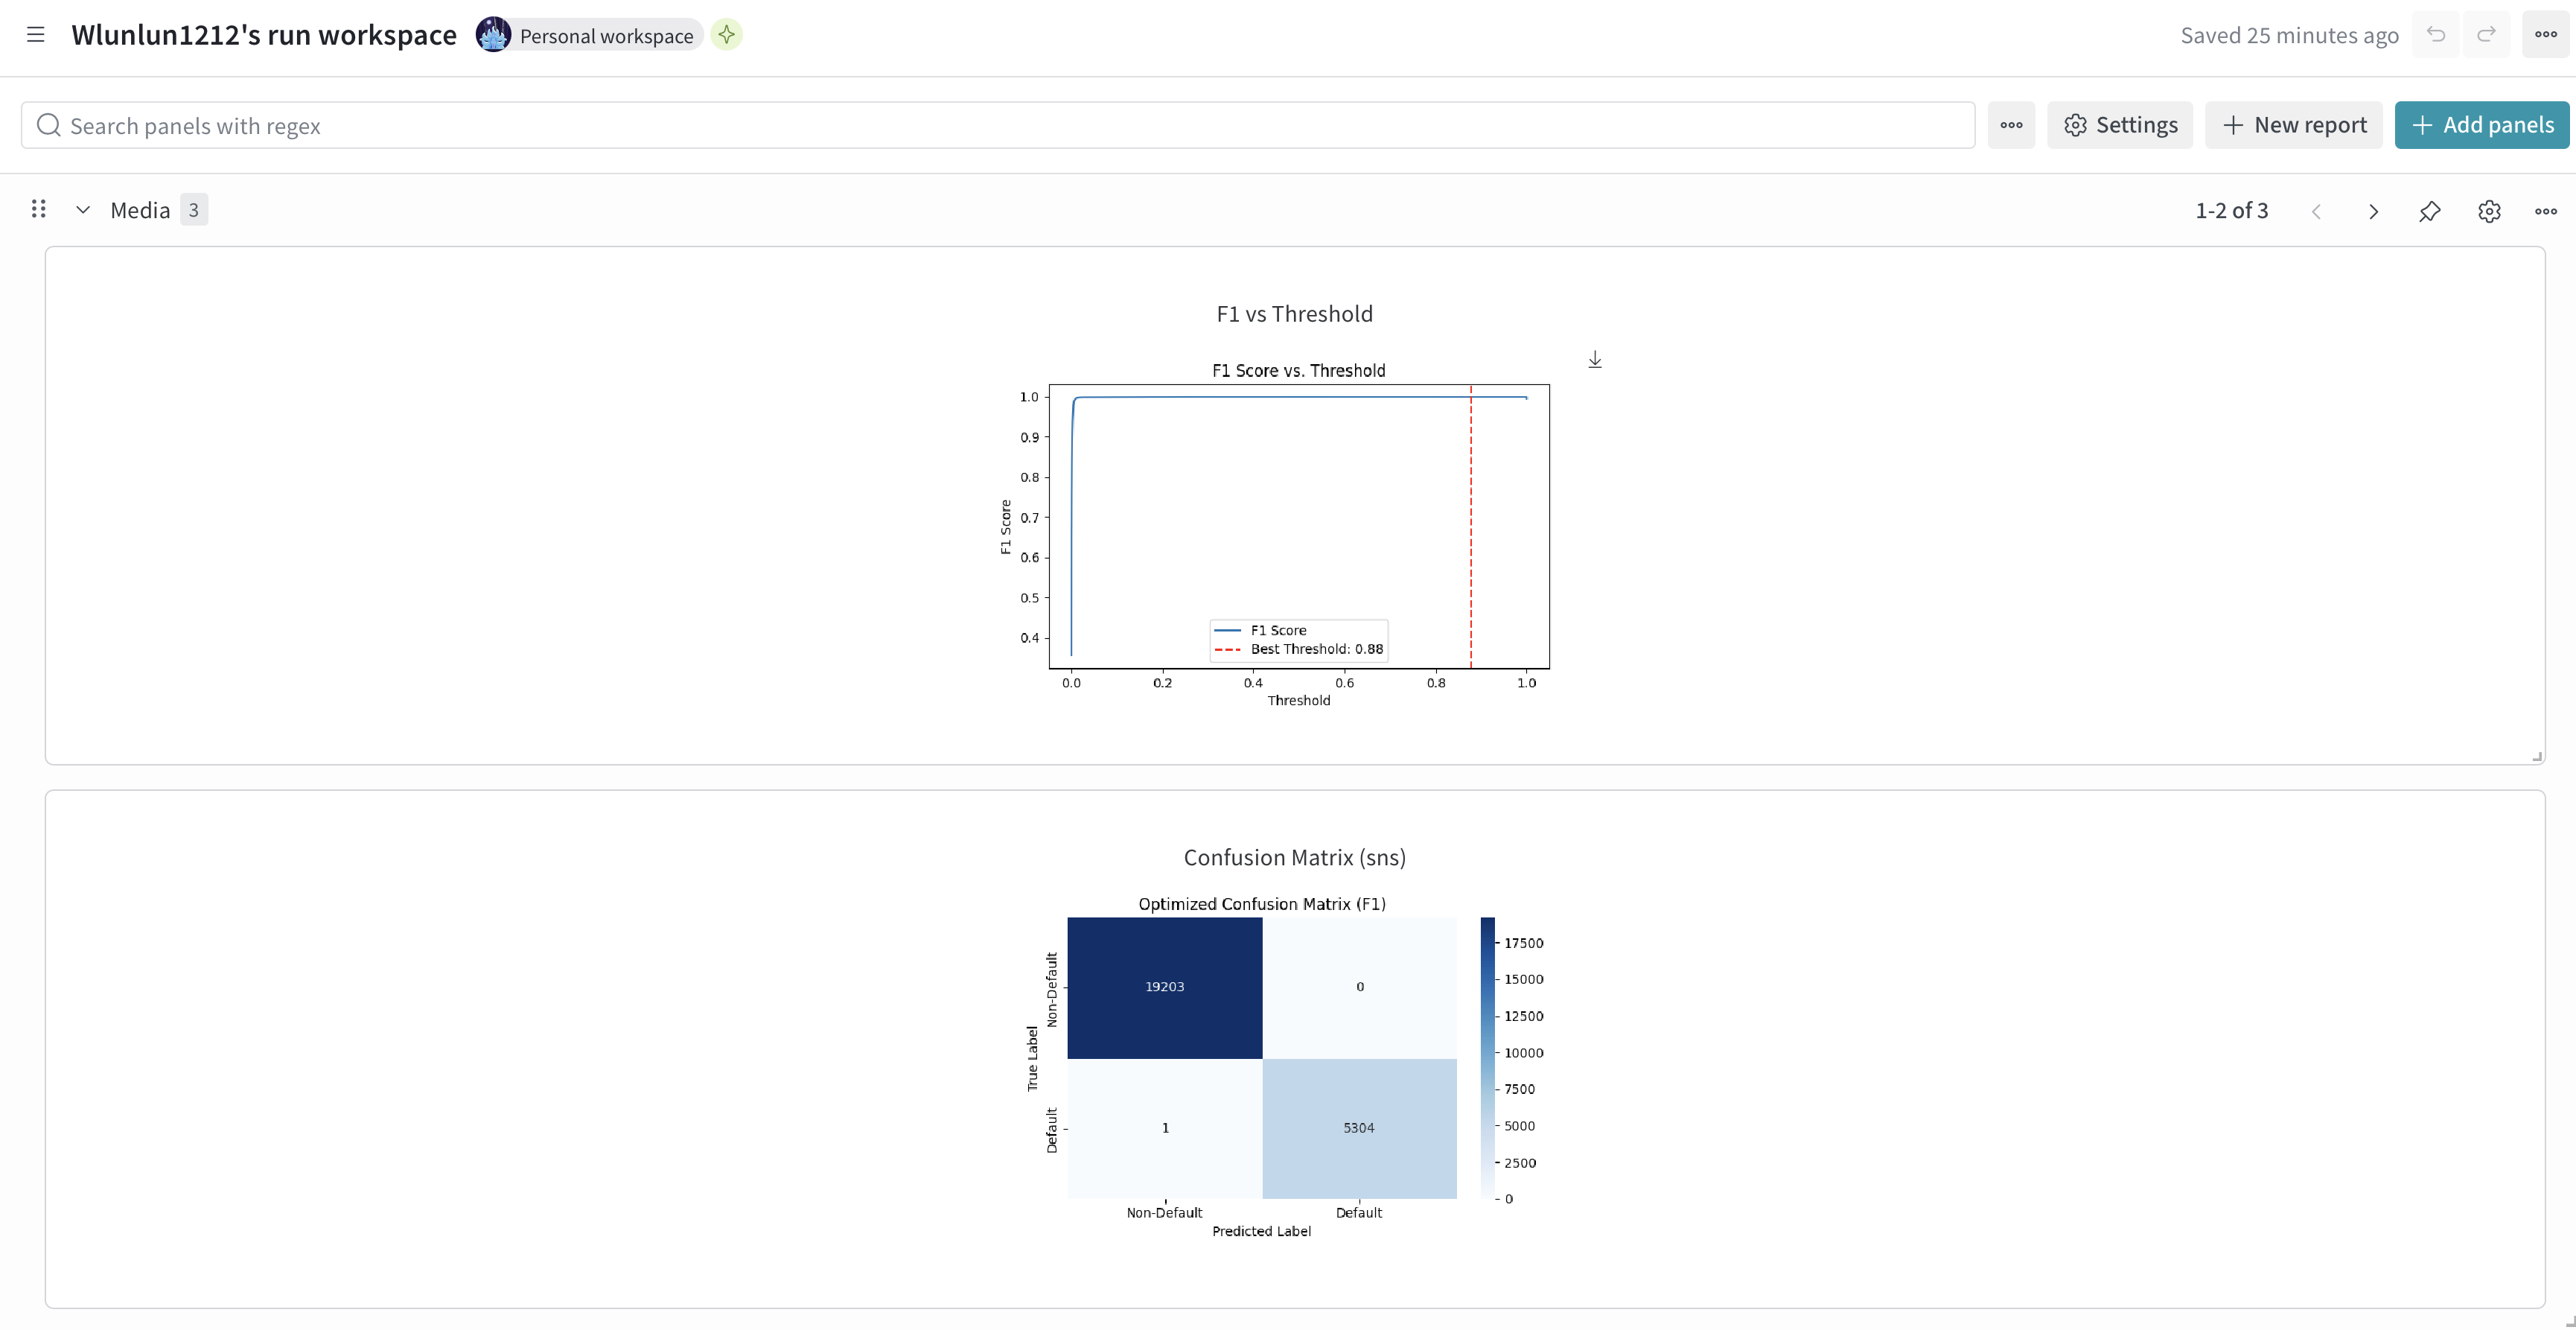

From the image, we have **overinflated metrics**. Focusing on the Default Class, we have Precision and Recall score which do way better than industry standard. However, since our metrics are all nearly perfect, it signals to us that our dataset has features which leak data (model peeks into future answers). This makes absolute sense as well, given that we have not dropped post loan origination features, and haven't done outlier handling, and feature engineering etc. For example, a Recall of 0.996 means that out of all actual defaulted loans, the Logistic Regression model predicted 99% of them correctly. This is unrealistic and signals high data leakage. 

As such, we will be dropping post-loan origination features to ensure our model only uses data available at the time of origination to predict future defaults. Before that, let's look into outlier / skewness detection & treatment. 

In [22]:
df4 = df3 

# 5. Post Loan Origination Features Removal

In credit risk modeling, there are normally features in the dataset, which 'tells our model' the answer, when it should not. Put simply, these are features that hint to the model that the borrower has defaulted in the corresponding record. This is termed as 'data leak' in the data realm and should not happen, since machine learning models are meant to predict the future, using past data. Similarly, we are trying to utilise features known at the time of loan origination, to predict a borrower's / loan's probability of default. As such, let's drop such features right from the start which aren't useful for PD Modeling. An example is `tot_coll_amt`, where the total collection amount (when borrower defaults) is recorded. 


In [23]:
# == Not available at loan origination == 
post_loan_origination_features = ['out_prncp', 
                                  'total_pymnt', 'total_rec_prncp', 'total_rec_int', 
                                  'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                                  'last_pymnt_amnt', 'tot_coll_amt'
                                  , 'last_fico_range_high', 'last_fico_range_low']



# == total_pymnt_inv, total_rec_prncp_inv, total_rec_int_inv, out_prncp_inv removed prvsly == 


df4 = df4.drop(*post_loan_origination_features) 
print('✅ Post Loan Origination Features Dropped ...')

# == Assert none of these columns are in df4.columns == 
assert not any(col in df4.columns for col in post_loan_origination_features), \
    f"Some post-loan origination features are still present in df4: {set(df4.columns) & set(post_loan_origination_features)}"

# == Resample due to changes in original df4 == 
train_pdf4 , test_pdf4 = sample_split_order(initial_df=df4, sample_frac=0.1, cut_off_date=CUT_DATE, date_col='issue_d')

# == Check model performance after dropping post loan origination features == 
run_model_checkpoint(train_pdf4, test_pdf4, 'log_reg_post_loan_done', 'Logistic Regression', NOTEBOOK_RUN_NAME)

✅ Post Loan Origination Features Dropped ...


train_pdf has 107560 rows, 65 columns
test_pdf has 26420 rows, 65 columns



✅ Best F1 Score = 0.4394 at threshold = 0.50

📄 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Non-Default     0.8706    0.6171    0.7222     20677
     Default     0.3269    0.6697    0.4394      5743

    accuracy                         0.6285     26420
   macro avg     0.5987    0.6434    0.5808     26420
weighted avg     0.7524    0.6285    0.6607     26420



Accuracy,▁
Best Threshold,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.6285
Best Threshold,0.4989
F1 Score,0.43937
Gini,0.3936
Model Type,Logistic Regression


All of metrics dropped after dropping post loan origination features. However, this is realistic, since our model should not have these features at the time of loan origination. Hence, we shall proceed on with subsequent steps of building the PD Model. 

In [24]:
df5 = df4 

# 6. Outlier Treatment
Before feature engineering, we will be dealing with outliers and skewed distributions, which can distort credit risk models. They can dominate learning, causing bias or overfitting in our PD Model. Let's first identify features which are highly skewed. 

### 6.1 Columns with Outliers 
Upon identifying highly skewed variables in our dataset, it seems we have some absurdly skewed variables. To investigate further, we will first be using `approxQuantile()` method, which is a relatively more computational effective way to identify outliers for big data. This shall be used in computing the % of outliers of these columns. We will be using the IQR method in detecting outliers. 

In [25]:
# == 1. Find outliers % per column, without sampling (may risk missing absurd placeholders) == 

numeric_df5 = df5.select([feature.name for feature in df5.schema if isinstance(feature.dataType, NumericType)])

outliers_dict = {}

for feature in numeric_df5.schema.fields: 
    col_name = feature.name 
    data_type = feature.dataType

    if isinstance(data_type, NumericType): 
        outlier_pct = compute_outlier_pct(numeric_df5, col_name) 
        if outlier_pct > 0: 
            outliers_dict[col_name] = outlier_pct


print('❌ Outlier Percentage by Feature (sorted):')
for k, v in sorted(outliers_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {round(v, 2)}%")

❌ Outlier Percentage by Feature (sorted):
num_accts_ever_120_pd: 22.51%
default_status: 19.94%
delinq_2yrs: 19.28%
pub_rec: 16.99%
pub_rec_bankruptcies: 12.51%
mths_since_recent_bc: 9.51%
bc_open_to_buy: 9.42%
mo_sin_old_il_acct: 8.49%
mo_sin_rcnt_rev_tl_op: 8.39%
pct_tl_nvr_dlq: 6.93%
total_rev_hi_lim: 6.52%
total_bc_limit: 6.4%
total_bal_ex_mort: 6.31%
revol_bal: 6.14%
avg_cur_bal: 5.82%
num_il_tl: 5.82%
total_il_high_credit_limit: 5.66%
mo_sin_rcnt_tl: 5.64%
num_tl_90g_dpd_24m: 5.45%
inq_last_6mths: 5.32%
num_actv_rev_tl: 5.32%
num_rev_tl_bal_gt_0: 4.98%
acc_open_past_24mths: 4.89%
annual_inc: 4.37%
num_bc_tl: 4.36%
num_bc_sats: 4.27%
num_op_rev_tl: 4.02%
tot_cur_bal: 3.96%
tot_hi_cred_lim: 3.83%
mths_since_recent_inq: 3.77%
mo_sin_old_rev_tl_op: 3.45%
open_acc: 3.44%
num_sats: 3.35%
installment: 3.22%
tax_liens: 3.22%
credit_history_years: 2.86%
num_tl_op_past_12m: 2.58%
num_rev_accts: 2.39%
fico_range_low: 2.31%
fico_range_high: 2.31%
num_actv_bc_tl: 1.99%
int_rate: 1.85%
total_ac

To ensure that our WoE & IV Feature Selection produce better binning (more balanced bins) and smoother WoE (if a feature separates good and bad outcomes properly), we should visualise our distributions to understand our dataset better. 

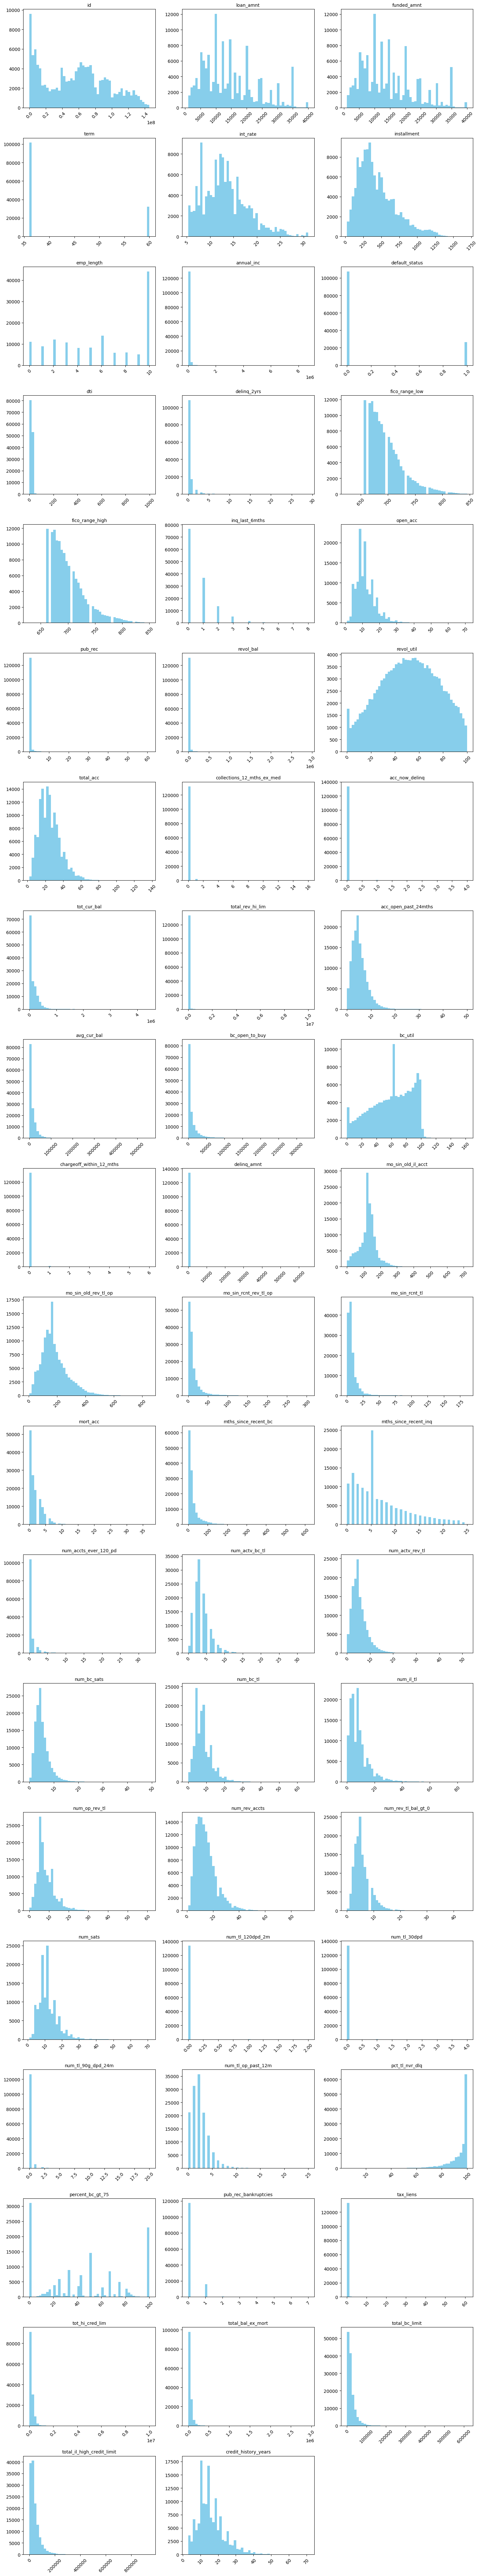

In [26]:
# == Check initial distribution, symmetry of numerical features    
display_distributions(df5)

From the original distribution of our cleaned dataset, we can observe that we have many skewed features, which is common is credit risk datasets. Before dealing with skewness, it is important to handle outliers first. Skewness measures the symmetry of a feature, and a few outliers can over-inflate the skewness of a feature, rendering the skewness value inaccurate. This can lead to us blindly applying transformations to a feature, when it does harm to our PD Model. 

As such, based on the nature of an outlier, they will be dealt in different ways. 
- **Clear Data Error**: Trim 
- **Real Outlier but Rare (Domain Knowledge Based)**: Winsorise till IQR Bounds 
- **Outlier is Real & Meaningful** : Let WoE binning handle this outlier 

### 6.2 Outlier Handling 

In [27]:
# == Check Outlier Values == 
outlier_columns = list(outliers_dict.keys())  
inspect_outliers_iqr(df5, outlier_columns)


📊 Inspecting Outliers for Column: `loan_amnt`
Q1 = 8000.0, Q3 = 20000.0, IQR = 12000.0
Lower Bound = -10000.0, Upper Bound = 38000.0
Outlier Count: 7120 (0.53%)
🔼 Top Outliers (>38000.0):
+---------+
|loan_amnt|
+---------+
|  40000.0|
|  40000.0|
|  40000.0|
|  40000.0|
|  40000.0|
+---------+
only showing top 5 rows
🔽 Bottom Outliers (<-10000.0):
+---------+
|loan_amnt|
+---------+
+---------+


📊 Inspecting Outliers for Column: `funded_amnt`
Q1 = 8000.0, Q3 = 20000.0, IQR = 12000.0
Lower Bound = -10000.0, Upper Bound = 38000.0
Outlier Count: 7120 (0.53%)
🔼 Top Outliers (>38000.0):
+-----------+
|funded_amnt|
+-----------+
|    40000.0|
|    40000.0|
|    40000.0|
|    40000.0|
|    40000.0|
+-----------+
only showing top 5 rows
🔽 Bottom Outliers (<-10000.0):
+-----------+
|funded_amnt|
+-----------+
+-----------+


📊 Inspecting Outliers for Column: `int_rate`
Q1 = 9.71, Q3 = 15.99, IQR = 6.279999999999999
Lower Bound = 0.2900000000000027, Upper Bound = 25.409999999999997
Outlier Co

In [28]:
# == DTI Outlier Handling == 
df5 = retain_rows(df5, 'dti', 120, '<=')  # Drop rows where dti > 120
df5 = winsorise_col(df5, 'dti','>', 100, 100)  # Winsorise dti > 100 to 100


# == Only allow fico_scores between 300 and 850 == 
df5 = df5.filter((col("last_fico_range_high") <= 850) & (col("last_fico_range_high") >= 300))
df5 = df5.filter((col("last_fico_range_low") <= 850) & (col("last_fico_range_low") >= 300))

# == total_rev_hi_lim == 
df5 = df5.filter(col("total_rev_hi_lim") < 9_999_999.0) # likely placeholders / data error 

# == months since oldest installment account opened == 
df5 = df5.filter(col("mo_sin_old_il_acct") < 999)  # Drop likely placeholders 
df5 = df5.filter(col("mo_sin_old_rev_tl_op") < 999)  # Drop likely placeholders 

# == high credit limit ==
df5 = df5.filter(col("tot_hi_cred_lim") < 9_999_999.0)  


✅ Winsorising column: dti ...


In [29]:
df6 = df5

# 7. Skewness Treatment 
It seems that each feature still have outliers. However, this is often normal in credit risk datasets, and it will be illogical if we simply drop them simply because we are outliers. Even if they are outliers, certain data points act as a crucial indicator to PD modeling, e.g. extremely high `dti` can signal high probability of default. 

In real life, it seems that credit risk modelers check the WoE and IV of each feature or build their PD models first, before improving on it, and improving their outlier handling methods manually per feature. For now, let's check out the skewness of features in our dataset. 

### 7.1 Base Feature Creation 
Let's obtain some base features from our dataset. 

First, a common derived feature in credit risk is the credit history length of the borrower at the time of loan issuance. Normally, it would be safe to say that loans with borrowers with a longer credit history has a lower probability of default. Hence, this can be taken into account as 1 of the features of the dataset. We can compute this as the difference between `issue_d` and `earliest_cr_line`. 

Second, it seems that we have 2 features related to FICO Scores: `fico_range_low` and `fico_range_high`. Upon further research, these features do not represent the lowest and highest scores ever recorded for a borrower, but rather the lower and upper bounds of a small range in which the borrower’s actual FICO score falls. Banks record these due to privacy concerns, through a 5 point window, as shown below. As such, it seems that we just need to average these 2 values, to minimise redundancy and multicollinearity. 

In [30]:
df6 = df6.withColumn('fico_score',  (col('fico_range_low') + col('fico_range_high')) / 2  )
df6 = df6.drop( col("fico_range_low")   , col('fico_range_high') ) 

# == Assert checks == 
expected_columns = set(df6.columns)

# == 1. Confirm 'fico_score' exists ==
assert 'fico_score' in expected_columns, "'fico_score' column is missing"

# == 2. Confirm 'fico_range_low' and 'fico_range_high' are removed == 
assert 'fico_range_low' not in expected_columns and 'fico_range_high' not in expected_columns, \
       "Old FICO range columns still present"

### 7.2 Highly Skewed Features Detection 

In [31]:
from pyspark.sql.functions import skewness
from pprint import pprint 

numeric_columns5 = [field.name for field in df6.schema.fields if isinstance(field.dataType, NumericType)]


# Compute skewness for each numeric column 
for column in numeric_columns5: 
    
    skew_val = df6.select(skewness(col(column))).collect()[0][0]
    
    if skew_val is not None and abs(skew_val) >= 1: 
        skew_val = round(skew_val, 2)  # Round to 2 decimal places
        print(f"{column}: {skew_val} 🚩")
        
    else: 
        print(f"{column}: {skew_val}")

id: 0.22412244358287056
loan_amnt: 0.7772571320837267
funded_amnt: 0.7787791094753803
term: 1.22 🚩
int_rate: 0.7194750465269774
installment: 1.0 🚩
emp_length: -0.23103893840903023
annual_inc: 45.35 🚩
default_status: 1.66 🚩
dti: 0.6075307991940314
delinq_2yrs: 5.58 🚩
inq_last_6mths: 1.7 🚩
open_acc: 1.3 🚩
pub_rec: 11.14 🚩
revol_bal: 10.38 🚩
revol_util: -0.07901153897861486
total_acc: 0.9537985626438297
collections_12_mths_ex_med: 15.03 🚩
acc_now_delinq: 21.59 🚩
tot_cur_bal: 2.96 🚩
total_rev_hi_lim: 6.15 🚩
acc_open_past_24mths: 1.42 🚩
avg_cur_bal: 3.71 🚩
bc_open_to_buy: 3.89 🚩
bc_util: -0.3839668263092948
chargeoff_within_12_mths: 18.09 🚩
delinq_amnt: 95.72 🚩
mo_sin_old_il_acct: 0.34228087514464256
mo_sin_old_rev_tl_op: 1.09 🚩
mo_sin_rcnt_rev_tl_op: 3.59 🚩
mo_sin_rcnt_tl: 4.56 🚩
mort_acc: 1.68 🚩
mths_since_recent_bc: 3.54 🚩
mths_since_recent_inq: 1.13 🚩
num_accts_ever_120_pd: 5.15 🚩
num_actv_bc_tl: 1.48 🚩
num_actv_rev_tl: 1.6 🚩
num_bc_sats: 1.79 🚩
num_bc_tl: 1.4 🚩
num_il_tl: 2.14 🚩
num_op

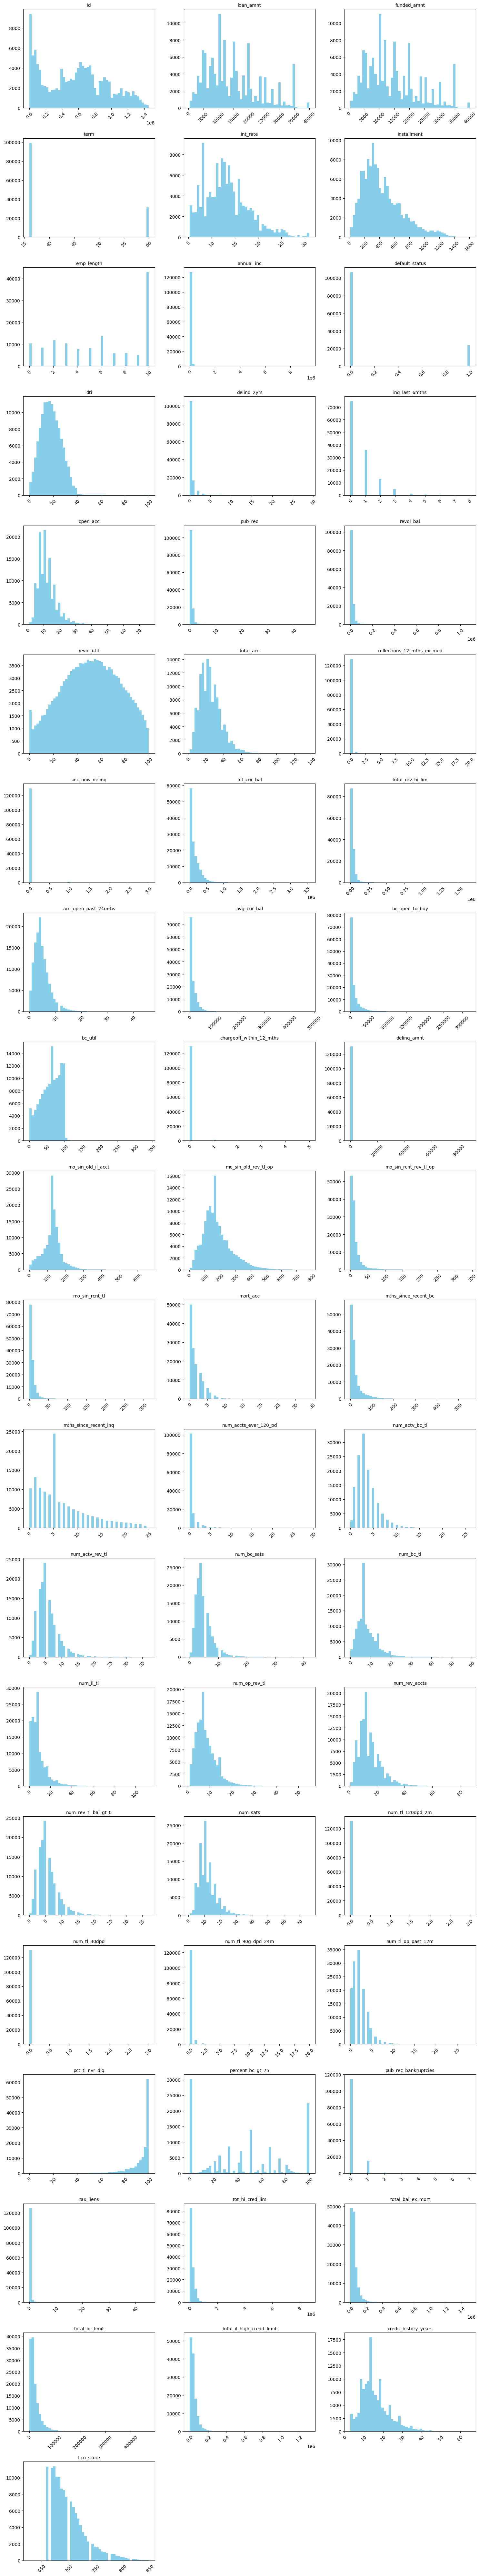

In [32]:
display_distributions(df6)

In [33]:
df7 = df6


Now, let's deal with skewness issues. We will group the following numerical features into the following categories
- **Highly Right Skewed (Pct / Probability)**: Logit Transformation
- **Highly Right Skewed (Continuous Feature)**: Log Transformation, Else Box-Cox 
- **Discrete Variables**: WoE binning in Feature Selection 


⚠️ However ... At this checkpoint, I chanced upon how the usage of WoE binning and Feature Selection was robust to outliers and skewness. For example, outliers can be binned into a separate category of itself in WoE binning. Upon this, the WoE encoding of continuous column replaces the original continuous column with each row's bin's WoE value (log-odds scale). Since we are not feeding raw scales of continuous values into our future model, there will not be skewness fixing or transformations needed. 

Since we still made some minor changes, i.e. removing placeholders and illogical values of some of our features, let's log it to `wandb` to simulate the adherence to strict Basel regulations. 

In [34]:
train_pdf7 , test_pdf7 = sample_split_order(df7, 0.1, CUT_DATE, 'issue_d')

run_model_checkpoint(train_pdf7, test_pdf7, 'log_reg_outlier_done', 'Logistic Regression', NOTEBOOK_RUN_NAME)


train_pdf has 104860 rows, 64 columns
test_pdf has 25595 rows, 64 columns



✅ Best F1 Score = 0.4118 at threshold = 0.51

📄 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Non-Default     0.8815    0.6479    0.7468     20627
     Default     0.3039    0.6383    0.4118      4968

    accuracy                         0.6460     25595
   macro avg     0.5927    0.6431    0.5793     25595
weighted avg     0.7694    0.6460    0.6818     25595



Accuracy,▁
Best Threshold,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.64602
Best Threshold,0.50876
F1 Score,0.41176
Gini,0.39519
Model Type,Logistic Regression


# 8. Feature Selection & Engineering (Next)

In [35]:
df7.write.format("delta").mode("overwrite").save("../data/gold/feature_selection_next")


In [36]:
# == Check if Gold Delta is accessible for feature engineering == 
gold_table = spark.read.format("delta")\
    .load("../data/gold/feature_selection_next")
    
gold = gold_table.limit(10).toPandas()
gold

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
0,7369532,33425.0,33425.0,60,15.10,796.94,C,4,RENT,75000.0,...,100.0,0.0,0.0,0.0,11649.0,5657.0,5000.0,0.0,10,742.0
1,6965099,7000.0,7000.0,36,18.25,253.95,D,4,OWN,50000.0,...,86.0,0.0,0.0,0.0,40127.0,4598.0,8400.0,27627.0,21,672.0
2,6975765,20000.0,20000.0,36,6.03,608.72,A,10,MORTGAGE,200000.0,...,98.0,0.0,0.0,0.0,527579.0,25040.0,51900.0,43306.0,40,782.0
3,6919540,2000.0,2000.0,36,9.71,64.27,B,10,MORTGAGE,40000.0,...,96.0,0.0,0.0,0.0,63733.0,9832.0,9600.0,19683.0,12,742.0
4,7091151,6075.0,6075.0,36,12.35,202.80,B,4,MORTGAGE,50000.0,...,88.0,0.0,0.0,0.0,168962.0,27368.0,4500.0,35241.0,17,752.0
5,6835512,8800.0,8800.0,36,15.88,308.87,C,8,RENT,60000.0,...,100.0,100.0,1.0,0.0,39203.0,19942.0,6000.0,31703.0,18,662.0
6,7089001,6500.0,6500.0,36,18.85,237.78,D,3,RENT,44000.0,...,98.0,100.0,1.0,0.0,79552.0,75059.0,2300.0,76552.0,10,662.0
7,6819237,15850.0,15850.0,60,13.68,366.18,C,3,MORTGAGE,64000.0,...,93.0,100.0,0.0,0.0,386747.0,18234.0,10000.0,13465.0,16,712.0
8,7369220,11300.0,11300.0,36,11.99,375.27,B,10,RENT,34500.0,...,100.0,0.0,1.0,0.0,19898.0,12306.0,9300.0,10598.0,10,672.0
9,7048791,35000.0,35000.0,60,15.22,836.70,C,10,MORTGAGE,84308.0,...,98.0,0.0,0.0,0.0,219294.0,190674.0,20500.0,192694.0,26,777.0
